In [54]:
%matplotlib inline

import json
import ast

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import List

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

from sklearn.model_selection import train_test_split

from jass.logs.game_log_entry import GameLogEntry
from jass.game.game_state import GameState
from jass.game.game_state_util import state_from_complete_game, observation_from_state
from jass.game.game_util import convert_int_encoded_cards_to_str_encoded, convert_one_hot_encoded_cards_to_str_encoded_list

from jass.game.rule_schieber import RuleSchieber

game_rule = RuleSchieber()
path_to_data = Path('../data')

## Dataset Structure for Model Training

### Simple
Features: (2x36 = 72)
- cards played in current round (9x9 = 36)
- valid cards (9x9 = 36)

Target: (9x9 = 36 -> only select one! / or probability)
- choose one of the valid cards in own hand
- one-hot-encoding of all cards
- select only cards that are available
- select only cards that are valid

### More Useful Information
Features: (4x36 = 144)
- already played cards (9x9 = 36)
- cards played in current round (9x9 = 36)
- cards in hand (9x9 = 36)
- valid cards (9x9 = 36)

Target: (9x9 = 36 -> only select one! / or probability)
- choose one of the valid cards in own hand
- one-hot-encoding of all cards
- select only cards that are available
- select only cards that are valid

## Simple Model

First we have to import the generated Dataset and do some preprocessing for the model to learn the data

### Preprocessing

In [2]:
data = pd.read_csv(path_to_data / 'card_prediction' / 'card_prediciton_0001.csv')

data.head()

,trump,played_cards,valid_cards,selected_card
0,TPTP,['TP'],"['TP', 'TP', 'TP', 'TP', 'TP', 'TP', 'TP', 'TP...",TP
1,HEARTS,[np.str_('HA')],[np.str_('H9')],H9
2,HEARTS,"[np.str_('HA'), np.str_('H9'), np.str_('H10'),...","[np.str_('DA'), np.str_('DK'), np.str_('D6'), ...",CJ
3,HEARTS,"[np.str_('HA'), np.str_('H9'), np.str_('H10'),...",[np.str_('S9')],S9
4,HEARTS,"[np.str_('HA'), np.str_('H9'), np.str_('H10'),...","[np.str_('DA'), np.str_('DK'), np.str_('D6'), ...",C6


In [3]:
data.count()

trump            3033190
played_cards     3033190
valid_cards      3033190
selected_card    3033190
dtype: int64

In [4]:
data['played_cards'] = data['played_cards'].str.replace(r"np\.str_\((.*?)\)", r"\1", regex=True)
data['played_cards'] = data['played_cards'].apply(ast.literal_eval)

data['valid_cards'] = data['valid_cards'].str.replace(r"np\.str_\((.*?)\)", r"\1", regex=True)
data['valid_cards'] = data['valid_cards'].apply(ast.literal_eval)

#### Remove template entry

In [5]:
data.drop(data.index[0], inplace=True)
data = data.reset_index()  # make sure indexes pair with number of rows
data.drop('index', axis=1, inplace=True)

#### Analyze correctness of the Data

<Axes: xlabel='trump'>

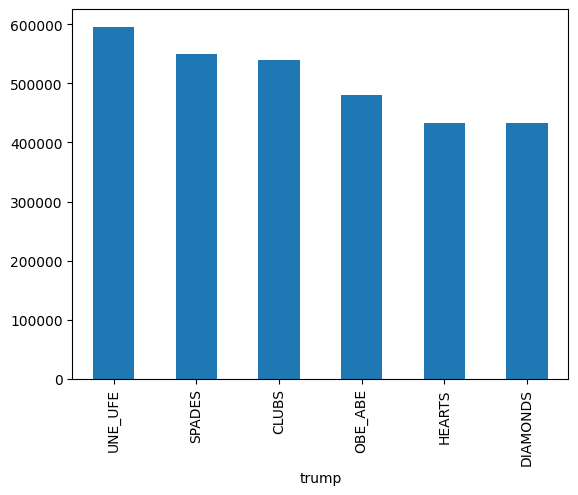

In [6]:
data['trump'].value_counts().plot(kind='bar')

#### Compare valid_cards & selected_card

Assert that the selected_card is part of the valid_cards

In [7]:
data['selected_card_valid'] = data.apply(
    lambda row: row['selected_card'] in row['valid_cards'], axis=1
)

In [8]:
data['selected_card_valid'].value_counts()

selected_card_valid
True    3033189
Name: count, dtype: int64

In [9]:
data.drop('selected_card_valid', axis=1, inplace=True)

#### Make Sure the amount of played cards is less than 36

In [10]:
data['played_cards'].map(lambda x: len(x)).max()

np.int64(35)

### One-Hot-Encode Played Cards

In [11]:
# Explode the lists into individual rows
exploded = data.explode('played_cards')

# Create one-hot encoding using get_dummies
played_cards_encoded = pd.get_dummies(exploded['played_cards'], prefix='played_cards')

# Group by the original index and sum to restore the original row structure
played_cards_encoded = played_cards_encoded.groupby(exploded.index).sum()

# Concatenate with the original DataFrame
data = pd.concat([data, played_cards_encoded], axis=1)

In [12]:
data.head()

,trump,played_cards,valid_cards,selected_card,played_cards_C10,played_cards_C6,played_cards_C7,played_cards_C8,played_cards_C9,played_cards_CA,...,played_cards_HQ,played_cards_S10,played_cards_S6,played_cards_S7,played_cards_S8,played_cards_S9,played_cards_SA,played_cards_SJ,played_cards_SK,played_cards_SQ
0,HEARTS,[HA],[H9],H9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HEARTS,"[HA, H9, H10, D10]","[DA, DK, D6, S9, CK, CJ, C8, C6]",CJ,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HEARTS,"[HA, H9, H10, D10, CJ, CA, C7, C10, S6, S10, SQ]",[S9],S9,1,0,1,0,0,1,...,0,1,1,0,0,0,0,0,0,1
3,HEARTS,"[HA, H9, H10, D10, CJ, CA, C7, C10, S6, S10, S...","[DA, DK, D6, CK, C8, C6]",C6,1,0,1,0,0,1,...,0,1,1,0,0,1,1,0,0,1
4,HEARTS,"[HA, H9, H10, D10, CJ, CA, C7, C10, S6, S10, S...","[DA, DK, D6, CK, C8]",C8,1,1,1,0,0,1,...,0,1,1,1,1,1,1,1,1,1


In [13]:
data.drop('played_cards', axis=1, inplace=True)

In [14]:
data.columns

Index(['trump', 'valid_cards', 'selected_card', 'played_cards_C10',
       'played_cards_C6', 'played_cards_C7', 'played_cards_C8',
       'played_cards_C9', 'played_cards_CA', 'played_cards_CJ',
       'played_cards_CK', 'played_cards_CQ', 'played_cards_D10',
       'played_cards_D6', 'played_cards_D7', 'played_cards_D8',
       'played_cards_D9', 'played_cards_DA', 'played_cards_DJ',
       'played_cards_DK', 'played_cards_DQ', 'played_cards_H10',
       'played_cards_H6', 'played_cards_H7', 'played_cards_H8',
       'played_cards_H9', 'played_cards_HA', 'played_cards_HJ',
       'played_cards_HK', 'played_cards_HQ', 'played_cards_S10',
       'played_cards_S6', 'played_cards_S7', 'played_cards_S8',
       'played_cards_S9', 'played_cards_SA', 'played_cards_SJ',
       'played_cards_SK', 'played_cards_SQ'],
      dtype='object')

### One-Hot-Encode Valid Cards

In [15]:
# Explode the lists into individual rows
exploded = data.explode('valid_cards')

# Create one-hot encoding using get_dummies
valid_cards_encoded = pd.get_dummies(exploded['valid_cards'], prefix='valid_cards')

# Group by the original index and sum to restore the original row structure
valid_cards_encoded = valid_cards_encoded.groupby(exploded.index).sum()

# Concatenate with the original DataFrame
data = pd.concat([data, valid_cards_encoded], axis=1)

data.columns

Index(['trump', 'valid_cards', 'selected_card', 'played_cards_C10',
       'played_cards_C6', 'played_cards_C7', 'played_cards_C8',
       'played_cards_C9', 'played_cards_CA', 'played_cards_CJ',
       'played_cards_CK', 'played_cards_CQ', 'played_cards_D10',
       'played_cards_D6', 'played_cards_D7', 'played_cards_D8',
       'played_cards_D9', 'played_cards_DA', 'played_cards_DJ',
       'played_cards_DK', 'played_cards_DQ', 'played_cards_H10',
       'played_cards_H6', 'played_cards_H7', 'played_cards_H8',
       'played_cards_H9', 'played_cards_HA', 'played_cards_HJ',
       'played_cards_HK', 'played_cards_HQ', 'played_cards_S10',
       'played_cards_S6', 'played_cards_S7', 'played_cards_S8',
       'played_cards_S9', 'played_cards_SA', 'played_cards_SJ',
       'played_cards_SK', 'played_cards_SQ', 'valid_cards_C10',
       'valid_cards_C6', 'valid_cards_C7', 'valid_cards_C8', 'valid_cards_C9',
       'valid_cards_CA', 'valid_cards_CJ', 'valid_cards_CK', 'valid_cards_CQ',
   

In [16]:
data.drop('valid_cards', axis=1, inplace=True)

### One-Hot-Encode Trump

In [17]:
data.trump = data.trump.astype('category')

# One-hot encode the 'trump' column
trump_encoded = pd.get_dummies(data['trump'], prefix='trump')

# Concatenate the encoded column back to the original DataFrame
data = pd.concat([data, trump_encoded], axis=1)

data.columns


Index(['trump', 'selected_card', 'played_cards_C10', 'played_cards_C6',
       'played_cards_C7', 'played_cards_C8', 'played_cards_C9',
       'played_cards_CA', 'played_cards_CJ', 'played_cards_CK',
       'played_cards_CQ', 'played_cards_D10', 'played_cards_D6',
       'played_cards_D7', 'played_cards_D8', 'played_cards_D9',
       'played_cards_DA', 'played_cards_DJ', 'played_cards_DK',
       'played_cards_DQ', 'played_cards_H10', 'played_cards_H6',
       'played_cards_H7', 'played_cards_H8', 'played_cards_H9',
       'played_cards_HA', 'played_cards_HJ', 'played_cards_HK',
       'played_cards_HQ', 'played_cards_S10', 'played_cards_S6',
       'played_cards_S7', 'played_cards_S8', 'played_cards_S9',
       'played_cards_SA', 'played_cards_SJ', 'played_cards_SK',
       'played_cards_SQ', 'valid_cards_C10', 'valid_cards_C6',
       'valid_cards_C7', 'valid_cards_C8', 'valid_cards_C9', 'valid_cards_CA',
       'valid_cards_CJ', 'valid_cards_CK', 'valid_cards_CQ', 'valid_cards_D10',

In [18]:
data.drop('trump', axis=1, inplace=True)

In [19]:
data.columns

Index(['selected_card', 'played_cards_C10', 'played_cards_C6',
       'played_cards_C7', 'played_cards_C8', 'played_cards_C9',
       'played_cards_CA', 'played_cards_CJ', 'played_cards_CK',
       'played_cards_CQ', 'played_cards_D10', 'played_cards_D6',
       'played_cards_D7', 'played_cards_D8', 'played_cards_D9',
       'played_cards_DA', 'played_cards_DJ', 'played_cards_DK',
       'played_cards_DQ', 'played_cards_H10', 'played_cards_H6',
       'played_cards_H7', 'played_cards_H8', 'played_cards_H9',
       'played_cards_HA', 'played_cards_HJ', 'played_cards_HK',
       'played_cards_HQ', 'played_cards_S10', 'played_cards_S6',
       'played_cards_S7', 'played_cards_S8', 'played_cards_S9',
       'played_cards_SA', 'played_cards_SJ', 'played_cards_SK',
       'played_cards_SQ', 'valid_cards_C10', 'valid_cards_C6',
       'valid_cards_C7', 'valid_cards_C8', 'valid_cards_C9', 'valid_cards_CA',
       'valid_cards_CJ', 'valid_cards_CK', 'valid_cards_CQ', 'valid_cards_D10',
       '

### One-Hot-Encode Selected Card

In [20]:
# One-hot encode the 'trump' column
selected_card_encoded = pd.get_dummies(data['selected_card'], prefix='selected_card')

# Concatenate the encoded column back to the original DataFrame
data = pd.concat([data, selected_card_encoded], axis=1)

data.columns

Index(['selected_card', 'played_cards_C10', 'played_cards_C6',
       'played_cards_C7', 'played_cards_C8', 'played_cards_C9',
       'played_cards_CA', 'played_cards_CJ', 'played_cards_CK',
       'played_cards_CQ',
       ...
       'selected_card_HQ', 'selected_card_S10', 'selected_card_S6',
       'selected_card_S7', 'selected_card_S8', 'selected_card_S9',
       'selected_card_SA', 'selected_card_SJ', 'selected_card_SK',
       'selected_card_SQ'],
      dtype='object', length=115)

In [21]:
data.drop('selected_card', axis=1, inplace=True)

### (Optional) Save Dataset for Training

In [76]:
data.to_csv(path_to_data / 'card_prediction' / 'card_prediciton_preprocessed_0001.csv', index=False)

# Card Play Prediction Model (DNN)

In [ ]:
data[data['trump_DIAMONDS'] == True]

In [ ]:
data = data.astype(np.float32)

In [ ]:
data.iloc[1].to_list()

In [78]:
feature_columns = played_cards_encoded.columns.to_list() + valid_cards_encoded.columns.to_list() + trump_encoded.columns.to_list()

In [79]:
# Split into features (X) and target (y)
X = np.asarray(data[ feature_columns ])
y = np.asarray(data[
    selected_card_encoded.columns
])

X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.]], dtype=float32)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Define Model

In [81]:
model = Sequential()

model.add(Dense(128, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(y_train.shape[1], activation="softmax"))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/Users/timon/.pyenv/versions/dl4g/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [82]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
30332/30332 ━━━━━━━━━━━━━━━━━━━━ 20s 641us/step - accuracy: 0.5453 - loss: 1.1962 - val_accuracy: 0.6045 - val_loss: 0.9317
Epoch 2/20
30332/30332 ━━━━━━━━━━━━━━━━━━━━ 19s 630us/step - accuracy: 0.6074 - loss: 0.9209 - val_accuracy: 0.6213 - val_loss: 0.8936
Epoch 3/20
30332/30332 ━━━━━━━━━━━━━━━━━━━━ 20s 668us/step - accuracy: 0.6187 - loss: 0.8937 - val_accuracy: 0.6254 - val_loss: 0.8822
Epoch 4/20
30332/30332 ━━━━━━━━━━━━━━━━━━━━ 20s 664us/step - accuracy: 0.6258 - loss: 0.8768 - val_accuracy: 0.6254 - val_loss: 0.8730
Epoch 5/20
30332/30332 ━━━━━━━━━━━━━━━━━━━━ 20s 665us/step - accuracy: 0.6320 - loss: 0.8628 - val_accuracy: 0.6256 - val_loss: 0.8684
Epoch 6/20
30332/30332 ━━━━━━━━━━━━━━━━━━━━ 21s 693us/step - accuracy: 0.6393 - loss: 0.8480 - val_accuracy: 0.6441 - val_loss: 0.8468
Epoch 7/20
30332/30332 ━━━━━━━━━━━━━━━━━━━━ 20s 651us/step - accuracy: 0.6438 - loss: 0.8388 - val_accuracy: 0.6514 - val_loss: 0.8276
Epoch 8/20
30332/30332 ━━━━━━━━━━━━━━━━━━━━ 20s 645us/s

In [83]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

18958/18958 ━━━━━━━━━━━━━━━━━━━━ 7s 344us/step - accuracy: 0.6719 - loss: 0.7847
Test Loss: 0.7838234901428223, Test Accuracy: 0.6716740727424622


In [88]:
model.save('card_prediction_v01.keras')